In [14]:
# https://www.kaggle.com/nolanbconaway/pitchfork-data

# scrape from genius
# https://chrishyland.github.io/scraping-from-genius/
# https://medium.com/analytics-vidhya/how-to-scrape-song-lyrics-a-gentle-python-tutorial-5b1d4ab351d2
import sqlite3
import pandas as pd

# import data
con = sqlite3.connect('pitchfork.sqlite')
genres = pd.read_sql('SELECT * FROM genres', con)
artists = pd.read_sql('SELECT * FROM artists', con)
reviews = pd.read_sql('SELECT * FROM reviews', con)
con.close()

scores = pd.concat([reviews['reviewid'], reviews['score']], axis=1)
albums = pd.concat([reviews['reviewid'], reviews['title']], axis=1)

genre_classes = genres['genre'].unique()
#genre_classes = ['None' if v is None else v for v in genre_classes]
genre_classes = [i for i in genre_classes if i]
print(genre_classes)

# combine genres and artists
data = pd.merge(pd.merge(pd.merge(genres, albums, on = 'reviewid'), artists, on='reviewid'), scores, on='reviewid') 

# remove 'various artists'
data = data[data.artist != 'various artists']

# remove None genre
data = data.dropna()

# sort by alphabetically by artist
data = data.sort_values(by=['score'], ascending=False)

df_train = data[0:15000]
df_test = data[15000:len(data)]


['electronic', 'metal', 'rock', 'rap', 'experimental', 'pop/r&b', 'folk/country', 'jazz', 'global']


In [15]:
# generate files of artist-album from each genre

# initialize empty genre.txt
for genre in genre_classes:
    if genre == 'pop/r&b':
        f = open("artist_album/pop-rnb.txt", "w+")
        f.close()
    elif genre == 'folk/country':
        f = open("artist_album/folk-country.txt", "w+")
        f.close()
    else:
        f = open("artist_album/"+genre+".txt", "w+")
        f.close()
    
# fill the genre.txt with artist_albums
for i, row in enumerate(data.itertuples()):
    if i < 1000:
        if row.genre == 'pop/r&b':
            f = open("artist_album/pop-rnb.txt", "a+")
            f.write(row.artist + "_" + row.title + ";")
            f.close()
            continue
        if row.genre == 'folk/country':
            f = open("artist_album/folk-country.txt", "a+")
            f.write(row.artist + "_" + row.title + ";")
            f.close()
            continue
        f = open("artist_album/"+row.genre+".txt", "a+")
        f.write(row.artist + "_" + row.title + ";")
        f.close()

In [43]:
# classifier (genre based on artist name)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

pipe = Pipeline([('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])
pipe.fit(df_train['artist'], df_train['genre'])
print(classification_report(y_true = df_test['genre'], y_pred=pipe.predict(df_test['artist'])))

              precision    recall  f1-score   support

  electronic       0.56      0.36      0.44      1186
experimental       0.67      0.15      0.25       611
folk/country       0.87      0.22      0.35       185
      global       1.00      0.07      0.14        55
        jazz       0.71      0.02      0.04       227
       metal       0.80      0.03      0.06       247
     pop/r&b       0.54      0.13      0.21       297
         rap       0.71      0.36      0.48       322
        rock       0.57      0.94      0.71      2944

    accuracy                           0.58      6074
   macro avg       0.72      0.25      0.30      6074
weighted avg       0.61      0.58      0.51      6074



AxesSubplot(0.125,0.125;0.775x0.755)


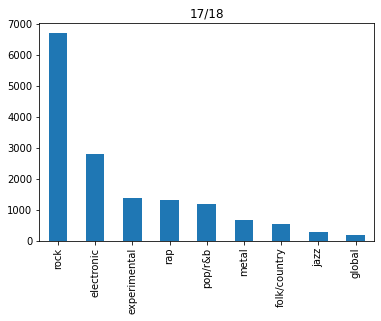

In [44]:
import matplotlib.pyplot as plt

print(df_train['genre'].value_counts().plot(kind="bar", title="17/18"))
